# Embedding-Based Ground Truth for Segmentation Evaluation

This notebook generates ground truth labels using LLM embeddings to evaluate different segmentation strategies.

**Key Features:**
- File-level embedding similarity (robust to path variations)
- Trace-level semantic similarity
- Automatic ground truth segment generation
- Evaluation of segmentation strategies
- **Self-contained:** All code is consolidated in this notebook (no external imports needed)

**Note:** This is NOT for representation rungs - it works on raw traces/events from the companion service.

**Consolidation:** This notebook now contains all code from `embedding_ground_truth.py` and `compare_segmentation_strategies.py`, making it fully self-contained.


In [ ]:
# Imports and setup
import sys
from pathlib import Path
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple, Set
from dataclasses import dataclass, field
from collections import defaultdict
from datetime import datetime
import os
import requests

# Load environment variables from .env file if it exists
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # dotenv not required, can use system environment variables

# For LLM embeddings - uses Hugging Face free embeddings
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Find repo root
def _find_repo_root() -> Path:
    current = Path.cwd().resolve()
    while True:
        if (current / "cursor-telemetry").exists() or (current / "components").exists():
            return current
        if current == current.parent:
            raise FileNotFoundError("Cannot locate repository root")
        current = current.parent

REPO_ROOT = _find_repo_root()
EXPORT_FILE_JSONL = REPO_ROOT / "research/data/companion_traces.jsonl"
RESULTS_DIR = REPO_ROOT / "research/results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repository root: {REPO_ROOT}")
print(f"JSONL file: {EXPORT_FILE_JSONL}")
print(f"Results directory: {RESULTS_DIR}")


Repository root: /Users/hamidaho/new_cursor
JSONL file: /Users/hamidaho/new_cursor/research/data/companion_traces.jsonl
Results directory: /Users/hamidaho/new_cursor/research/results


In [ ]:
# Core classes and functions for embedding-based ground truth generation
# Uses free Hugging Face sentence-transformers (no API key needed)

try:
    from sentence_transformers import SentenceTransformer
    HAS_SENTENCE_TRANSFORMERS = True
except ImportError:
    HAS_SENTENCE_TRANSFORMERS = False
    print("Warning: sentence-transformers not installed. Install with: pip install sentence-transformers")

@dataclass
class Trace:
    """A single trace event."""
    id: str = ""
    type: str = ""
    timestamp: str = ""
    workspace_path: Optional[str] = None
    file_path: Optional[str] = None
    details: Dict = field(default_factory=dict)

@dataclass
class GroundTruthResult:
    """Result from ground truth generation."""
    ground_truth_segments: List[List[int]] = field(default_factory=list)
    file_embeddings: Dict[str, np.ndarray] = field(default_factory=dict)
    trace_embeddings: np.ndarray = None

class EmbeddingGroundTruthGenerator:
    """Generate ground truth segments using free Hugging Face embeddings."""
    
    def __init__(
        self,
        embedding_model: Optional[str] = None,
        similarity_threshold: float = 0.75,
        file_similarity_threshold: float = 0.80
    ):
        self.similarity_threshold = similarity_threshold
        self.file_similarity_threshold = file_similarity_threshold
        
        # Use free sentence-transformers model (no API key needed)
        if embedding_model is None:
            embedding_model = 'all-mpnet-base-v2'  # Free, high-quality model
        
        if HAS_SENTENCE_TRANSFORMERS:
            try:
                print(f"Loading embedding model: {embedding_model}")
                self.model = SentenceTransformer(embedding_model)
                self.use_local = True
                print(f"✓ Using local sentence-transformers model (free, no API needed)")
            except Exception as e:
                print(f"Error loading model: {e}")
                raise
        else:
            raise ImportError("sentence-transformers is required. Install with: pip install sentence-transformers")
    
    def generate_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings for a list of texts using local model."""
        if not self.use_local:
            raise RuntimeError("Local model not available")
        
        embeddings = self.model.encode(texts, convert_to_numpy=True, show_progress_bar=True)
        # Normalize embeddings for cosine similarity
        embeddings = normalize(embeddings, norm='l2')
        return embeddings
    
    def generate_file_level_embeddings(self, traces: List[Trace]) -> Dict[str, np.ndarray]:
        """Generate embeddings for unique file paths."""
        file_contexts = {}
        
        for trace in traces:
            if trace.file_path:
                file_path = trace.file_path
                if file_path not in file_contexts:
                    file_contexts[file_path] = file_path
        
        if not file_contexts:
            return {}
        
        all_files = list(file_contexts.keys())
        all_contexts = [file_contexts[f] for f in all_files]
        
        print(f"  Generating embeddings for {len(all_files)} unique files...")
        embeddings = self.generate_embeddings(all_contexts)
        
        file_embeddings = {}
        for file_path, embedding in zip(all_files, embeddings):
            file_embeddings[file_path] = embedding
        
        return file_embeddings
    
    def generate_trace_level_embeddings(self, traces: List[Trace], file_embeddings: Dict[str, np.ndarray]) -> np.ndarray:
        """Generate embeddings for traces."""
        trace_texts = []
        
        for trace in traces:
            parts = []
            if trace.type:
                parts.append(f"Type: {trace.type}")
            if trace.file_path:
                parts.append(f"File: {trace.file_path}")
            if trace.details:
                if 'diff_summary' in trace.details:
                    parts.append(f"Change: {trace.details['diff_summary']}")
            
            trace_text = " | ".join(parts) if parts else str(trace.id)
            trace_texts.append(trace_text)
        
        print(f"  Generating embeddings for {len(traces)} traces...")
        embeddings = self.generate_embeddings(trace_texts)
        return embeddings
    
    def generate_ground_truth(self, traces: List[Trace]) -> GroundTruthResult:
        """Generate ground truth segments using embeddings."""
        if not traces:
            return GroundTruthResult()
        
        print(f"Generating ground truth for {len(traces)} traces...")
        
        print("  Generating file-level embeddings...")
        file_embeddings = self.generate_file_level_embeddings(traces)
        print(f"  Found {len(file_embeddings)} unique files")
        
        print("  Generating trace-level embeddings...")
        trace_embeddings = self.generate_trace_level_embeddings(traces, file_embeddings)
        
        print("  Clustering traces into segments...")
        segments = self._cluster_traces(traces, trace_embeddings, file_embeddings)
        
        return GroundTruthResult(
            ground_truth_segments=segments,
            file_embeddings=file_embeddings,
            trace_embeddings=trace_embeddings
        )
    
    def _cluster_traces(
        self,
        traces: List[Trace],
        trace_embeddings: np.ndarray,
        file_embeddings: Dict[str, np.ndarray]
    ) -> List[List[int]]:
        """Cluster traces into segments using embeddings and heuristics."""
        n_traces = len(traces)
        if n_traces == 0:
            return []
        if n_traces == 1:
            return [[0]]
        
        similarity_matrix = cosine_similarity(trace_embeddings)
        segments = []
        used = set()
        
        for i in range(n_traces):
            if i in used:
                continue
            
            segment = [i]
            used.add(i)
            
            for j in range(i + 1, n_traces):
                if j in used:
                    continue
                
                similarity = similarity_matrix[i][j]
                
                file_sim = 0.0
                if traces[i].file_path and traces[j].file_path:
                    if traces[i].file_path == traces[j].file_path:
                        file_sim = 1.0
                    elif traces[i].file_path in file_embeddings and traces[j].file_path in file_embeddings:
                        file_sim = float(np.dot(
                            file_embeddings[traces[i].file_path],
                            file_embeddings[traces[j].file_path]
                        ))
                
                workspace_match = (
                    traces[i].workspace_path and traces[j].workspace_path and
                    traces[i].workspace_path == traces[j].workspace_path
                )
                
                temporal_prox = False
                if traces[i].timestamp and traces[j].timestamp:
                    try:
                        t1 = datetime.fromisoformat(traces[i].timestamp.replace('Z', '+00:00'))
                        t2 = datetime.fromisoformat(traces[j].timestamp.replace('Z', '+00:00'))
                        gap_minutes = abs((t2 - t1).total_seconds() / 60)
                        temporal_prox = gap_minutes < 5.0
                    except:
                        pass
                
                should_group = False
                if similarity >= self.similarity_threshold:
                    should_group = True
                elif file_sim >= self.file_similarity_threshold and workspace_match:
                    should_group = True
                elif workspace_match and temporal_prox:
                    should_group = True
                
                if should_group:
                    segment.append(j)
                    used.add(j)
            
            segments.append(segment)
        
        return segments

def evaluate_segmentation_strategy(
    ground_truth: GroundTruthResult,
    predicted_segments: List[List[int]],
    traces: List[Trace]
) -> Dict[str, float]:
    """Evaluate predicted segments against ground truth."""
    gt_segments = ground_truth.ground_truth_segments
    gt_sets = [set(seg) for seg in gt_segments]
    pred_sets = [set(seg) for seg in predicted_segments]
    
    precisions = []
    for pred_seg in pred_sets:
        if len(pred_seg) == 0:
            continue
        max_jaccard = 0.0
        for gt_seg in gt_sets:
            intersection = len(pred_seg & gt_seg)
            union = len(pred_seg | gt_seg)
            if union > 0:
                jaccard = intersection / union
                max_jaccard = max(max_jaccard, jaccard)
        precisions.append(max_jaccard)
    
    precision = np.mean(precisions) if precisions else 0.0
    
    matched_gt = set()
    for gt_seg in gt_sets:
        for pred_seg in pred_sets:
            intersection = len(gt_seg & pred_seg)
            if intersection > 0 and intersection / len(gt_seg) >= 0.5:
                matched_gt.add(id(gt_seg))
                break
    
    recall = len(matched_gt) / len(gt_sets) if gt_sets else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    n_traces = len(traces)
    gt_labels = np.zeros(n_traces, dtype=int)
    pred_labels = np.zeros(n_traces, dtype=int)
    
    for i, seg in enumerate(gt_segments):
        for idx in seg:
            if 0 <= idx < n_traces:
                gt_labels[idx] = i
    
    for i, seg in enumerate(predicted_segments):
        for idx in seg:
            if 0 <= idx < n_traces:
                pred_labels[idx] = i
    
    ari = adjusted_rand_score(gt_labels, pred_labels)
    nmi = normalized_mutual_info_score(gt_labels, pred_labels)
    
    gt_boundaries = set()
    pred_boundaries = set()
    
    for seg in gt_segments:
        if len(seg) > 1:
            for i in range(len(seg) - 1):
                if seg[i] + 1 == seg[i + 1]:
                    gt_boundaries.add(seg[i])
    
    for seg in predicted_segments:
        if len(seg) > 1:
            for i in range(len(seg) - 1):
                if seg[i] + 1 == seg[i + 1]:
                    pred_boundaries.add(seg[i])
    
    if pred_boundaries:
        boundary_precision = len(gt_boundaries & pred_boundaries) / len(pred_boundaries)
    else:
        boundary_precision = 0.0
    
    if gt_boundaries:
        boundary_recall = len(gt_boundaries & pred_boundaries) / len(gt_boundaries)
    else:
        boundary_recall = 0.0
    
    boundary_f1 = (2 * boundary_precision * boundary_recall / 
                   (boundary_precision + boundary_recall) 
                   if (boundary_precision + boundary_recall) > 0 else 0.0)
    
    completeness = _calculate_completeness(traces, predicted_segments)
    homogeneity = _calculate_homogeneity(traces, predicted_segments)
    
    return {
        'completeness': completeness,
        'homogeneity': homogeneity,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'ari': ari,
        'nmi': nmi,
        'boundary_precision': boundary_precision,
        'boundary_recall': boundary_recall,
        'boundary_f1': boundary_f1
    }

def _calculate_completeness(traces: List[Trace], segments: List[List[int]]) -> float:
    """Calculate completeness: ratio of properly grouped related events."""
    related_groups = []
    used = set()
    
    for i, trace_i in enumerate(traces):
        if i in used:
            continue
        
        group = [i]
        used.add(i)
        
        for j, trace_j in enumerate(traces[i+1:], start=i+1):
            if j in used:
                continue
            
            same_file = trace_i.file_path and trace_j.file_path and trace_i.file_path == trace_j.file_path
            same_workspace = (trace_i.workspace_path and trace_j.workspace_path and 
                            trace_i.workspace_path == trace_j.workspace_path)
            
            temporal_prox = False
            if trace_i.timestamp and trace_j.timestamp:
                try:
                    t1 = datetime.fromisoformat(trace_i.timestamp.replace('Z', '+00:00'))
                    t2 = datetime.fromisoformat(trace_j.timestamp.replace('Z', '+00:00'))
                    gap_minutes = abs((t2 - t1).total_seconds() / 60)
                    temporal_prox = gap_minutes < 5.0
                except:
                    pass
            
            if (same_file or (same_workspace and temporal_prox)):
                group.append(j)
                used.add(j)
        
        if len(group) > 1:
            related_groups.append(group)
    
    if not related_groups:
        return 1.0
    
    properly_grouped = 0
    for group in related_groups:
        segment_ids = set()
        for idx in group:
            for seg_idx, seg in enumerate(segments):
                if idx in seg:
                    segment_ids.add(seg_idx)
                    break
        
        if len(segment_ids) == 1:
            properly_grouped += 1
    
    return properly_grouped / len(related_groups) if related_groups else 1.0

def _calculate_homogeneity(traces: List[Trace], segments: List[List[int]]) -> float:
    """Calculate homogeneity: ratio of segments representing a single task."""
    if not segments:
        return 1.0
    
    homogeneous_count = 0
    
    for seg in segments:
        if len(seg) <= 1:
            homogeneous_count += 1
            continue
        
        seg_traces = [traces[idx] for idx in seg if 0 <= idx < len(traces)]
        
        files = set(t.file_path for t in seg_traces if t.file_path)
        file_diversity = len(files)
        
        types = set(t.type for t in seg_traces if t.type)
        type_diversity = len(types)
        
        timestamps = [t.timestamp for t in seg_traces if t.timestamp]
        time_span_minutes = 0
        if len(timestamps) > 1:
            try:
                times = [datetime.fromisoformat(ts.replace('Z', '+00:00')) for ts in timestamps]
                time_span_minutes = (max(times) - min(times)).total_seconds() / 60
            except:
                pass
        
        is_homogeneous = (
            file_diversity <= 3 and
            type_diversity <= 2 and
            time_span_minutes < 30
        )
        
        if is_homogeneous:
            homogeneous_count += 1
    
    return homogeneous_count / len(segments)

print("Core classes and functions loaded successfully!")


Core classes and functions loaded successfully!


## Load Companion Service Data

Load traces from the companion database or exported JSONL file.


In [ ]:
def load_traces_from_jsonl(file_path: Path) -> List[Dict]:
    """
    Load traces from companion_traces.jsonl file.
    
    Structure: Each line is a session with:
    {
        "session_id": "...",
        "workspace_path": "...",
        "events": [
            {
                "id": "...",
                "type": "code_change",
                "timestamp": "...",
                "details": {"file_path": "...", ...},
                "annotation": null,
                "intent": null,
                "tags": null,
                "ai_generated": false
            }
        ]
    }
    """
    traces = []
    if not file_path.exists():
        return traces
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            
            session = json.loads(line)
            workspace_path = session.get('workspace_path')
            session_id = session.get('session_id')
            
            # Extract events from this session
            for event in session.get('events', []):
                # Add session context to event
                event['workspace_path'] = workspace_path
                event['session_id'] = session_id
                traces.append(event)
    
    return traces

# Load traces from JSONL
print("Loading traces from JSONL...")
traces_data = load_traces_from_jsonl(EXPORT_FILE_JSONL)
print(f"Loaded {len(traces_data)} events from {EXPORT_FILE_JSONL}")

# Convert to Trace objects
# Structure: event has id, type, timestamp, details (dict with file_path), workspace_path, session_id
traces = []
for event in traces_data:
    details = event.get('details', {})
    file_path = details.get('file_path')
    
    trace = Trace(
        id=event.get('id', ''),
        type=event.get('type', ''),
        timestamp=event.get('timestamp', ''),
        workspace_path=event.get('workspace_path'),
        file_path=file_path,
        details=details
    )
    traces.append(trace)

print(f"Converted to {len(traces)} Trace objects")
if traces:
    sample = traces[0]
    print(f"Sample trace:")
    print(f"  - ID: {sample.id}")
    print(f"  - Type: {sample.type}")
    print(f"  - File: {sample.file_path}")
    print(f"  - Timestamp: {sample.timestamp}")
    print(f"  - Workspace: {sample.workspace_path}")


Loading traces from JSONL...
Loaded 5537 events from /Users/hamidaho/new_cursor/research/data/companion_traces.jsonl
Converted to 5537 Trace objects
Sample trace:
  - ID: e876a074-9da4-4123-89b3-7ba0ef86ffd2
  - Type: code_change
  - File: new_cursor/test-persistence.js
  - Timestamp: 2025-10-23T04:20:18.843Z
  - Workspace: /Users/hamidaho


## Generate Embedding-Based Ground Truth

Generate ground truth segments using LLM embeddings. This defines which traces should be grouped together based on semantic similarity.


In [ ]:
# Configure embedding generator
# Uses HF_TOKEN, HUGGINGFACE_API_KEY, or HF_API_KEY from .env file
# Get a free token at: https://huggingface.co/settings/tokens
generator = EmbeddingGroundTruthGenerator(
    embedding_model=None,  # Defaults to sentence-transformers/all-mpnet-base-v2 (free)
    similarity_threshold=0.75,
    file_similarity_threshold=0.80
)

# Generate ground truth
print("Generating embedding-based ground truth...")
print(f"This will create embeddings for {len(traces)} traces")

ground_truth = generator.generate_ground_truth(traces)

print(f"\nGenerated ground truth:")
print(f"  - {len(ground_truth.ground_truth_segments)} segments")
print(f"  - {len(ground_truth.file_embeddings)} unique files")
print(f"  - Average segment size: {np.mean([len(s) for s in ground_truth.ground_truth_segments]):.1f} traces")

# Save ground truth segments to JSON
ground_truth_file = RESULTS_DIR / 'ground_truth_segments.json'
ground_truth_data = {
    'segments': [
        {
            'segment_id': i,
            'trace_indices': segment,
            'n_traces': len(segment)
        }
        for i, segment in enumerate(ground_truth.ground_truth_segments)
    ],
    'metadata': {
        'total_segments': len(ground_truth.ground_truth_segments),
        'total_traces': sum(len(s) for s in ground_truth.ground_truth_segments),
        'unique_files': len(ground_truth.file_embeddings),
        'average_segment_size': np.mean([len(s) for s in ground_truth.ground_truth_segments]) if ground_truth.ground_truth_segments else 0
    }
}
with open(ground_truth_file, 'w') as f:
    json.dump(ground_truth_data, f, indent=2)
print(f"\nSaved ground truth segments to: {ground_truth_file}")


Loading embedding model: all-mpnet-base-v2
✓ Using local sentence-transformers model (free, no API needed)
Generating embedding-based ground truth...
This will create embeddings for 5537 traces
Generating ground truth for 5537 traces...
  Generating file-level embeddings...
  Generating embeddings for 2098 unique files...


Batches:   0%|          | 0/66 [00:00<?, ?it/s]

  Found 2098 unique files
  Generating trace-level embeddings...
  Generating embeddings for 5537 traces...


Batches:   0%|          | 0/174 [00:00<?, ?it/s]

  Clustering traces into segments...

Generated ground truth:
  - 27 segments
  - 2098 unique files
  - Average segment size: 205.1 traces

Saved ground truth segments to: /Users/hamidaho/new_cursor/research/results/ground_truth_segments.json


## Evaluate Segmentation Strategies

Compare different segmentation strategies against the ground truth.


In [ ]:
def calculate_inactivity_periods(traces: List[Trace]) -> List[float]:
    """
    Calculate inactivity periods (gaps) between consecutive traces.
    Returns list of inactivity durations in minutes.
    """
    inactivity_periods = []
    
    for i in range(1, len(traces)):
        if traces[i].timestamp and traces[i-1].timestamp:
            try:
                t1 = datetime.fromisoformat(traces[i-1].timestamp.replace('Z', '+00:00'))
                t2 = datetime.fromisoformat(traces[i].timestamp.replace('Z', '+00:00'))
                gap_minutes = (t2 - t1).total_seconds() / 60
                inactivity_periods.append(gap_minutes)
            except:
                pass
    
    return inactivity_periods

def segment_by_inactivity(traces: List[Trace], inactivity_threshold_percentile: float = 75.0) -> List[List[int]]:
    """
    Segment traces based on inactivity periods.
    
    Uses statistical analysis of inactivity periods to determine boundaries:
    - Calculates all inactivity periods between consecutive traces
    - Uses a percentile threshold (e.g., 75th percentile) to identify significant gaps
    - Creates segment boundaries at significant inactivity periods
    
    Args:
        traces: List of traces
        inactivity_threshold_percentile: Percentile threshold for inactivity (0-100)
                                        Higher = more sensitive (fewer segments)
                                        Lower = less sensitive (more segments)
    
    Returns:
        List of segments (each segment is a list of trace indices)
    """
    if len(traces) < 2:
        return [[0]] if traces else []
    
    # Calculate inactivity periods
    inactivity_periods = calculate_inactivity_periods(traces)
    
    if not inactivity_periods:
        return [list(range(len(traces)))]
    
    # Calculate threshold based on percentile
    threshold = np.percentile(inactivity_periods, inactivity_threshold_percentile)
    
    # Segment based on inactivity threshold
    segments = []
    current_segment = [0]
    
    for i in range(1, len(traces)):
        if traces[i].timestamp and traces[i-1].timestamp:
            try:
                t1 = datetime.fromisoformat(traces[i-1].timestamp.replace('Z', '+00:00'))
                t2 = datetime.fromisoformat(traces[i].timestamp.replace('Z', '+00:00'))
                gap_minutes = (t2 - t1).total_seconds() / 60
                
                # If gap exceeds threshold, create new segment
                if gap_minutes > threshold:
                    segments.append(current_segment)
                    current_segment = [i]
                else:
                    current_segment.append(i)
            except:
                current_segment.append(i)
        else:
            current_segment.append(i)
    
    if current_segment:
        segments.append(current_segment)
    
    return segments

# Analyze inactivity periods in the data
print("Analyzing inactivity periods in traces...")
inactivity_periods = calculate_inactivity_periods(traces)

if inactivity_periods:
    print(f"\nInactivity Statistics:")
    print(f"  Total periods: {len(inactivity_periods)}")
    print(f"  Min: {np.min(inactivity_periods):.2f} minutes")
    print(f"  Max: {np.max(inactivity_periods):.2f} minutes")
    print(f"  Median: {np.median(inactivity_periods):.2f} minutes")
    print(f"  Mean: {np.mean(inactivity_periods):.2f} minutes")
    print(f"  25th percentile: {np.percentile(inactivity_periods, 25):.2f} minutes")
    print(f"  50th percentile: {np.percentile(inactivity_periods, 50):.2f} minutes")
    print(f"  75th percentile: {np.percentile(inactivity_periods, 75):.2f} minutes")
    print(f"  90th percentile: {np.percentile(inactivity_periods, 90):.2f} minutes")
    print(f"  95th percentile: {np.percentile(inactivity_periods, 95):.2f} minutes")
    
    # Show distribution
    print(f"\nInactivity Distribution:")
    print(f"  < 5 min: {sum(1 for p in inactivity_periods if p < 5)} ({100*sum(1 for p in inactivity_periods if p < 5)/len(inactivity_periods):.1f}%)")
    print(f"  5-15 min: {sum(1 for p in inactivity_periods if 5 <= p < 15)} ({100*sum(1 for p in inactivity_periods if 5 <= p < 15)/len(inactivity_periods):.1f}%)")
    print(f"  15-30 min: {sum(1 for p in inactivity_periods if 15 <= p < 30)} ({100*sum(1 for p in inactivity_periods if 15 <= p < 30)/len(inactivity_periods):.1f}%)")
    print(f"  30-60 min: {sum(1 for p in inactivity_periods if 30 <= p < 60)} ({100*sum(1 for p in inactivity_periods if 30 <= p < 60)/len(inactivity_periods):.1f}%)")
    print(f"  >= 60 min: {sum(1 for p in inactivity_periods if p >= 60)} ({100*sum(1 for p in inactivity_periods if p >= 60)/len(inactivity_periods):.1f}%)")
    
    # Save inactivity statistics to JSON
    inactivity_stats_file = RESULTS_DIR / 'inactivity_statistics.json'
    inactivity_stats = {
        'total_periods': len(inactivity_periods),
        'min_minutes': float(np.min(inactivity_periods)),
        'max_minutes': float(np.max(inactivity_periods)),
        'median_minutes': float(np.median(inactivity_periods)),
        'mean_minutes': float(np.mean(inactivity_periods)),
        'percentiles': {
            '25th': float(np.percentile(inactivity_periods, 25)),
            '50th': float(np.percentile(inactivity_periods, 50)),
            '75th': float(np.percentile(inactivity_periods, 75)),
            '90th': float(np.percentile(inactivity_periods, 90)),
            '95th': float(np.percentile(inactivity_periods, 95))
        },
        'distribution': {
            'less_than_5_min': {
                'count': int(sum(1 for p in inactivity_periods if p < 5)),
                'percentage': float(100*sum(1 for p in inactivity_periods if p < 5)/len(inactivity_periods))
            },
            '5_to_15_min': {
                'count': int(sum(1 for p in inactivity_periods if 5 <= p < 15)),
                'percentage': float(100*sum(1 for p in inactivity_periods if 5 <= p < 15)/len(inactivity_periods))
            },
            '15_to_30_min': {
                'count': int(sum(1 for p in inactivity_periods if 15 <= p < 30)),
                'percentage': float(100*sum(1 for p in inactivity_periods if 15 <= p < 30)/len(inactivity_periods))
            },
            '30_to_60_min': {
                'count': int(sum(1 for p in inactivity_periods if 30 <= p < 60)),
                'percentage': float(100*sum(1 for p in inactivity_periods if 30 <= p < 60)/len(inactivity_periods))
            },
            'greater_than_60_min': {
                'count': int(sum(1 for p in inactivity_periods if p >= 60)),
                'percentage': float(100*sum(1 for p in inactivity_periods if p >= 60)/len(inactivity_periods))
            }
        },
        'all_periods': [float(p) for p in inactivity_periods]
    }
    with open(inactivity_stats_file, 'w') as f:
        json.dump(inactivity_stats, f, indent=2)
    print(f"\nSaved inactivity statistics to: {inactivity_stats_file}")
else:
    print("  No inactivity periods found (need at least 2 traces with timestamps)")
    # Save empty statistics
    inactivity_stats_file = RESULTS_DIR / 'inactivity_statistics.json'
    with open(inactivity_stats_file, 'w') as f:
        json.dump({'total_periods': 0, 'message': 'No inactivity periods found'}, f, indent=2)

# Define strategies to test (using different percentile thresholds)
strategies = [
    {
        'name': 'Inactivity (50th percentile)',
        'func': lambda t: segment_by_inactivity(t, inactivity_threshold_percentile=50.0),
        'percentile': 50.0
    },
    {
        'name': 'Inactivity (75th percentile)',
        'func': lambda t: segment_by_inactivity(t, inactivity_threshold_percentile=75.0),
        'percentile': 75.0
    },
    {
        'name': 'Inactivity (90th percentile)',
        'func': lambda t: segment_by_inactivity(t, inactivity_threshold_percentile=90.0),
        'percentile': 90.0
    },
    {
        'name': 'Inactivity (95th percentile)',
        'func': lambda t: segment_by_inactivity(t, inactivity_threshold_percentile=95.0),
        'percentile': 95.0
    },
]

# Evaluate each strategy
print(f"\n{'='*80}")
print("EVALUATING TEMPORAL SEGMENTATION STRATEGIES")
print(f"{'='*80}\n")

results = []
for strategy in strategies:
    name = strategy['name']
    func = strategy['func']
    percentile = strategy['percentile']
    
    print(f"Evaluating: {name}...")
    
    # Generate segments
    predicted_segments = func(traces)
    
    # Calculate threshold for this percentile
    threshold = np.percentile(inactivity_periods, percentile) if inactivity_periods else 0
    
    print(f"  Threshold: {threshold:.2f} minutes")
    print(f"  Generated {len(predicted_segments)} segments")
    if predicted_segments:
        print(f"  Average segment size: {np.mean([len(s) for s in predicted_segments]):.1f} traces")
        print(f"  Segment size range: {min([len(s) for s in predicted_segments])} - {max([len(s) for s in predicted_segments])} traces")
    
    # Evaluate against ground truth
    evaluation = evaluate_segmentation_strategy(ground_truth, predicted_segments, traces)
    
    results.append({
        'strategy': name,
        'percentile': percentile,
        'threshold_minutes': threshold,
        'n_segments': len(predicted_segments),
        'avg_segment_size': np.mean([len(s) for s in predicted_segments]) if predicted_segments else 0,
        'completeness': evaluation['completeness'],
        'homogeneity': evaluation['homogeneity'],
        'precision': evaluation.get('precision', 0.0),
        'recall': evaluation.get('recall', 0.0),
        'f1': evaluation.get('f1', 0.0),
        'ari': evaluation.get('ari', 0.0),
        'nmi': evaluation.get('nmi', 0.0),
        'boundary_precision': evaluation.get('boundary_precision', 0.0),
        'boundary_recall': evaluation.get('boundary_recall', 0.0),
        'boundary_f1': evaluation.get('boundary_f1', 0.0)
    })
    
    print(f"  Completeness: {evaluation['completeness']:.3f}")
    print(f"  Homogeneity: {evaluation['homogeneity']:.3f}")
    print(f"  Precision: {evaluation.get('precision', 0.0):.3f}")
    print(f"  Recall: {evaluation.get('recall', 0.0):.3f}")
    print(f"  F1: {evaluation.get('f1', 0.0):.3f}")
    print(f"  ARI: {evaluation.get('ari', 0.0):.3f}")
    print(f"  NMI: {evaluation.get('nmi', 0.0):.3f}")
    print(f"  Boundary F1: {evaluation.get('boundary_f1', 0.0):.3f}")
    print()

# Create results dataframe
results_df = pd.DataFrame(results)

# Sort by F1 score (as primary metric)
results_df = results_df.sort_values('f1', ascending=False)

print(f"{'='*80}")
print("RESULTS SUMMARY")
print(f"{'='*80}")
print("\nIndividual Scores:")
print(results_df[['strategy', 'threshold_minutes', 'completeness', 'homogeneity', 'precision', 'recall', 'f1', 'ari', 'nmi', 'boundary_f1', 'n_segments', 'avg_segment_size']].to_string(index=False))


Analyzing inactivity periods in traces...

Inactivity Statistics:
  Total periods: 5536
  Min: -3872.01 minutes
  Max: 3043.28 minutes
  Median: 0.01 minutes
  Mean: 4.15 minutes
  25th percentile: 0.00 minutes
  50th percentile: 0.01 minutes
  75th percentile: 0.13 minutes
  90th percentile: 0.63 minutes
  95th percentile: 1.72 minutes

Inactivity Distribution:
  < 5 min: 5378 (97.1%)
  5-15 min: 57 (1.0%)
  15-30 min: 25 (0.5%)
  30-60 min: 15 (0.3%)
  >= 60 min: 61 (1.1%)

Saved inactivity statistics to: /Users/hamidaho/new_cursor/research/results/inactivity_statistics.json

EVALUATING TEMPORAL SEGMENTATION STRATEGIES

Evaluating: Inactivity (50th percentile)...
  Threshold: 0.01 minutes
  Generated 2769 segments
  Average segment size: 2.0 traces
  Segment size range: 1 - 143 traces


/Users/hamidaho/new_cursor/venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/Users/hamidaho/new_cursor/venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)


  Completeness: 0.047
  Homogeneity: 0.912
  Precision: 0.007
  Recall: 0.222
  F1: 0.014
  ARI: 0.004
  NMI: 0.299
  Boundary F1: 0.620

Evaluating: Inactivity (75th percentile)...
  Threshold: 0.13 minutes
  Generated 1385 segments
  Average segment size: 4.0 traces
  Segment size range: 1 - 210 traces
  Completeness: 0.116
  Homogeneity: 0.864
  Precision: 0.011
  Recall: 0.296
  F1: 0.021
  ARI: 0.021
  NMI: 0.317
  Boundary F1: 0.806

Evaluating: Inactivity (90th percentile)...
  Threshold: 0.63 minutes
  Generated 555 segments
  Average segment size: 10.0 traces
  Segment size range: 1 - 482 traces
  Completeness: 0.227
  Homogeneity: 0.712
  Precision: 0.020
  Recall: 0.370
  F1: 0.039
  ARI: 0.025
  NMI: 0.288
  Boundary F1: 0.879

Evaluating: Inactivity (95th percentile)...
  Threshold: 1.72 minutes
  Generated 278 segments
  Average segment size: 19.9 traces
  Segment size range: 1 - 490 traces
  Completeness: 0.407
  Homogeneity: 0.576
  Precision: 0.031
  Recall: 0.407
  F1

## Visualize Results

Create visualizations comparing inactivity-based temporal segmentation strategies.


Computing bootstrap confidence intervals (this may take a minute)...
  ✓ Inactivity (95th percentile): CI computed
  ✓ Inactivity (90th percentile): CI computed
  ✓ Inactivity (75th percentile): CI computed
  ✓ Inactivity (50th percentile): CI computed

Saved bootstrap results to: /Users/hamidaho/new_cursor/research/results/bootstrap_results.json
Saved: /Users/hamidaho/new_cursor/research/results/completeness_vs_homogeneity.png


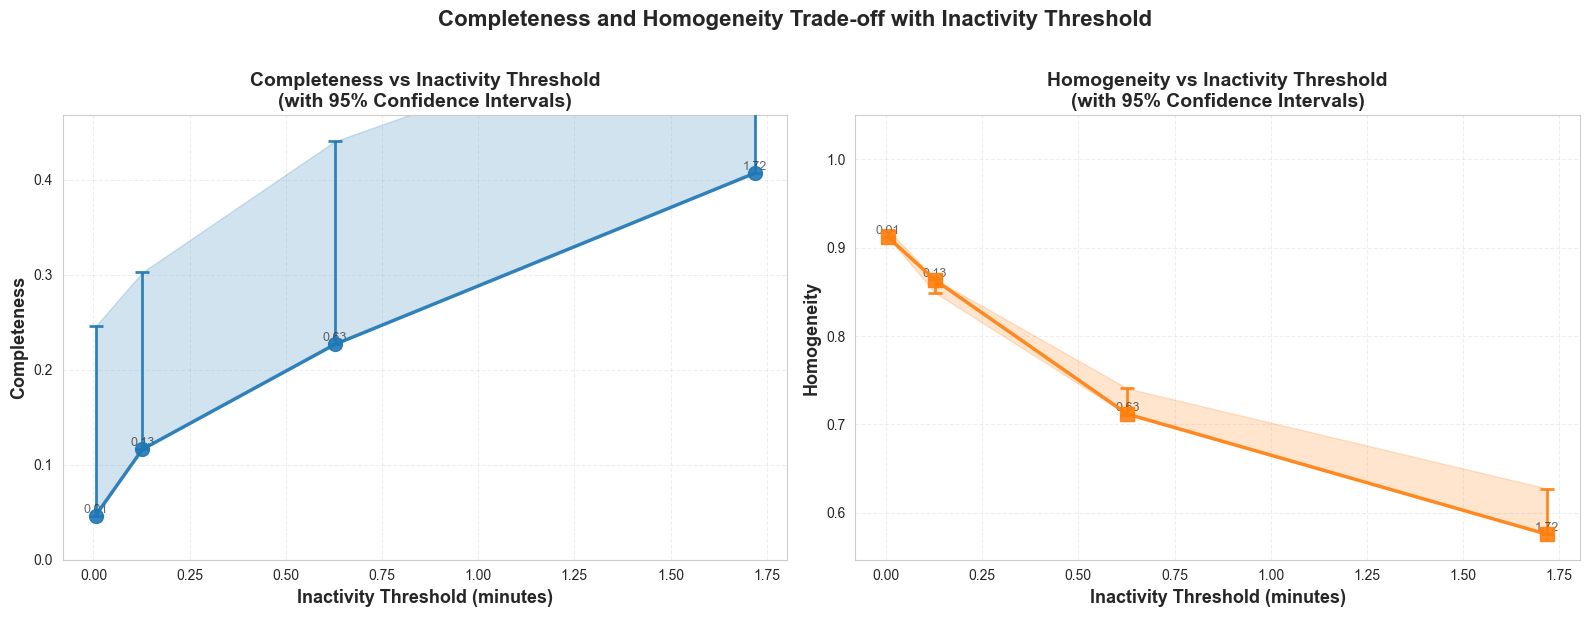

/var/folders/44/9ttt0k9s3wl7sq_tvdjvdhph0000gn/T/ipykernel_39624/1199912314.py:262: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((x_lower, y_lower), width, height,


Saved: /Users/hamidaho/new_cursor/research/results/completeness_vs_homogeneity_scatter.png


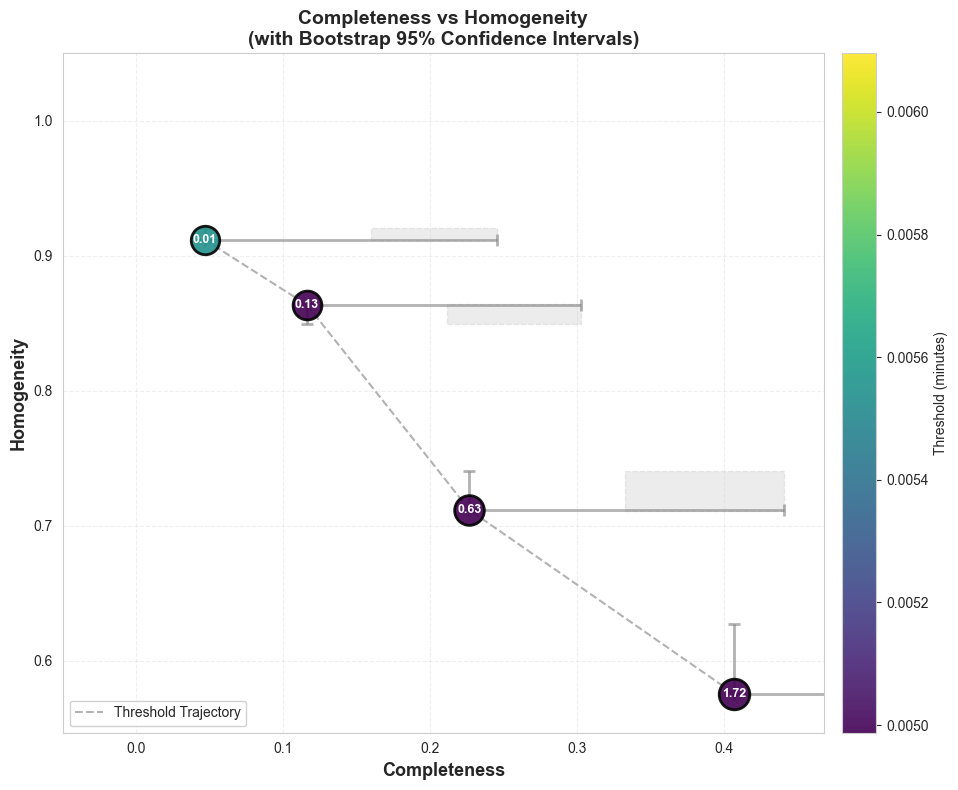

Saved: /Users/hamidaho/new_cursor/research/results/metrics_vs_threshold_main.png


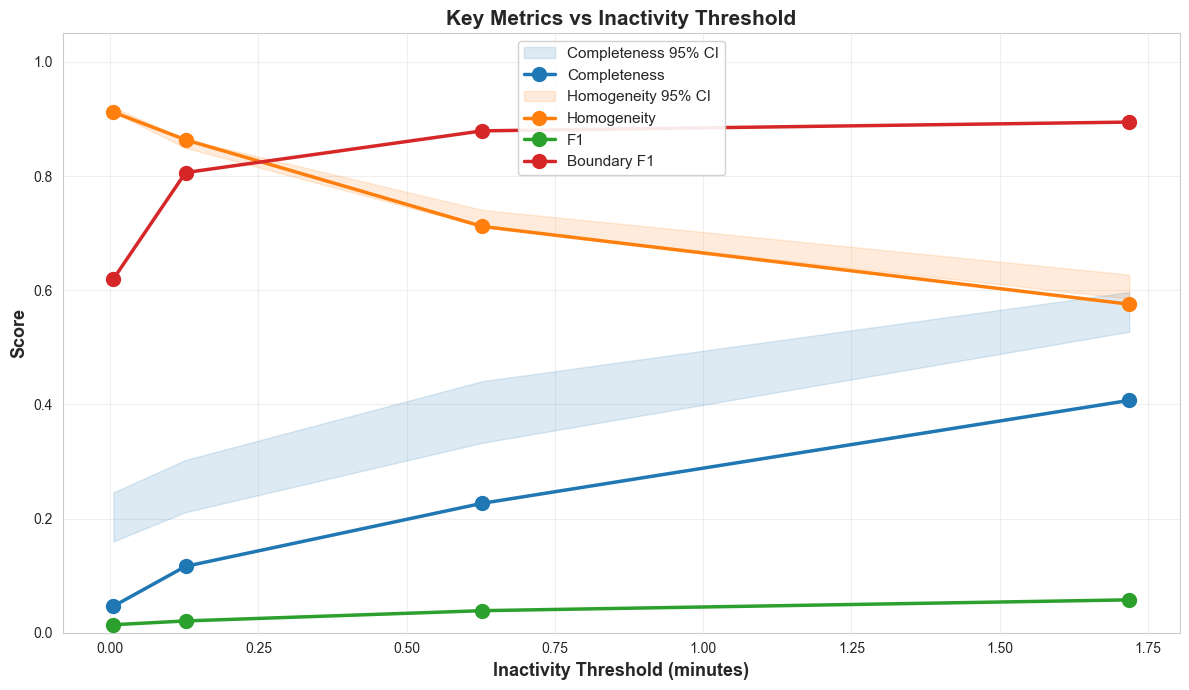

Saved: /Users/hamidaho/new_cursor/research/results/metrics_vs_threshold_all.png


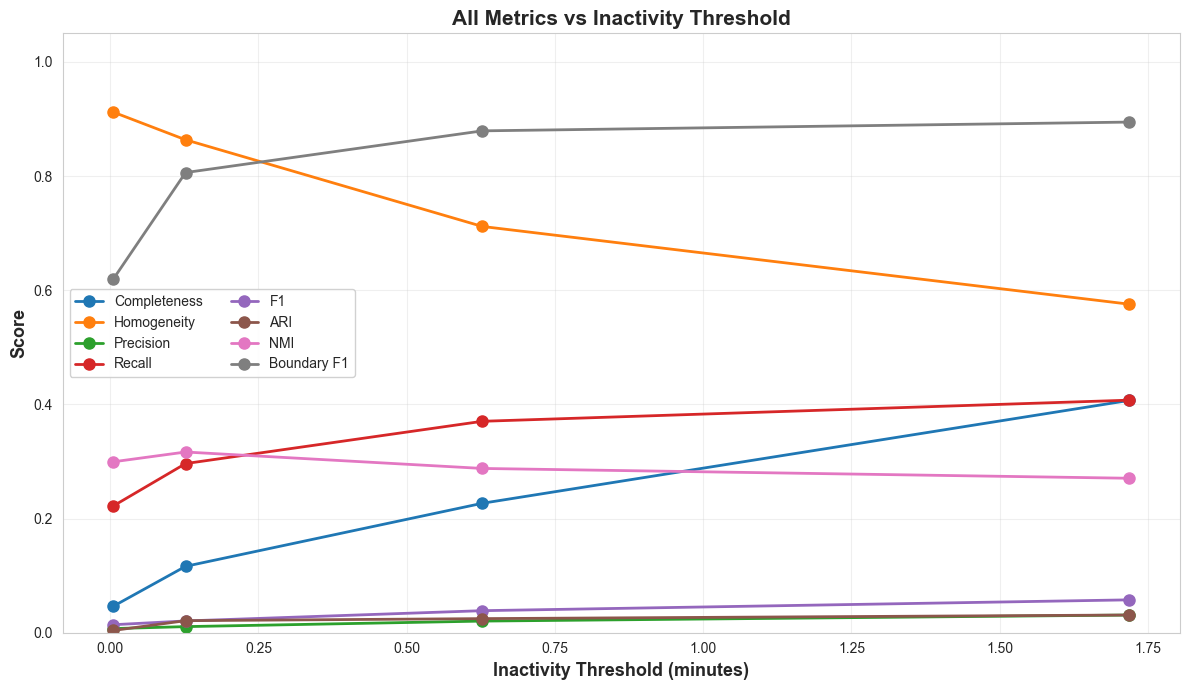

Saved: /Users/hamidaho/new_cursor/research/results/segments_vs_threshold.png


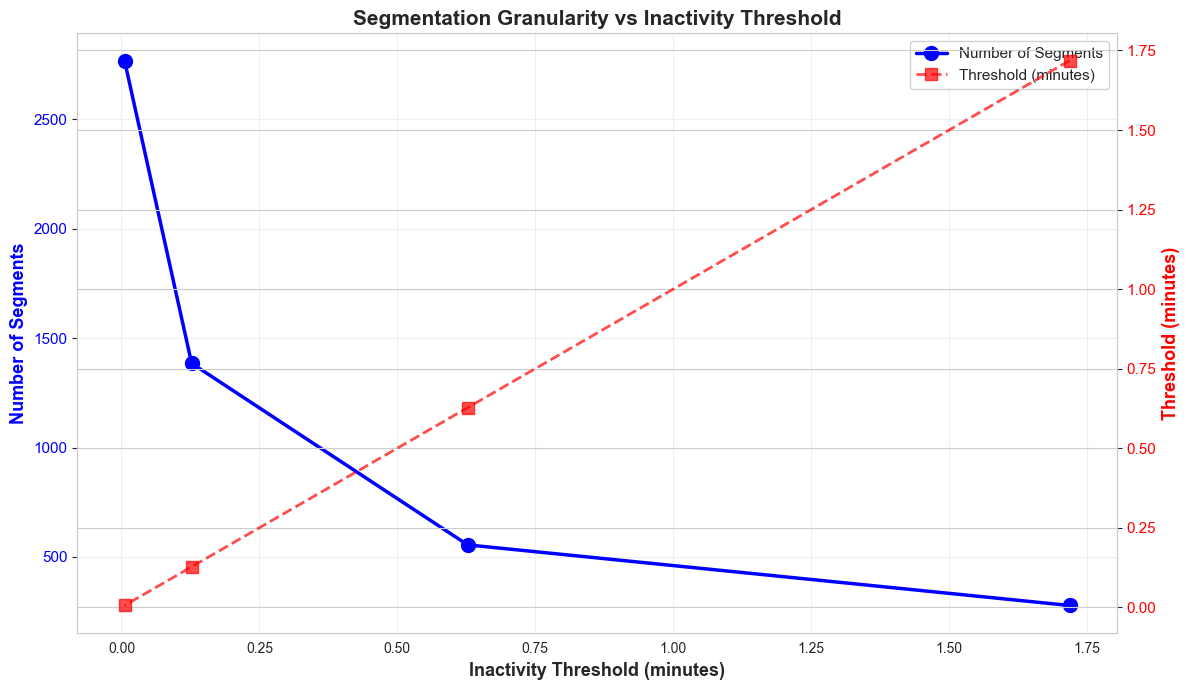

Saved: /Users/hamidaho/new_cursor/research/results/f1_vs_segments.png


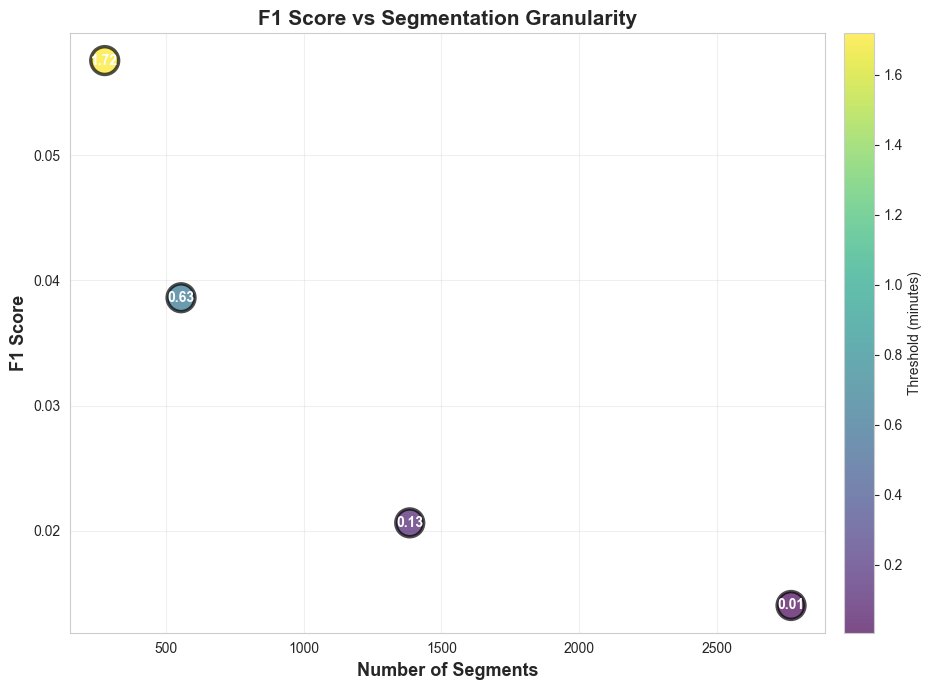

Saved: /Users/hamidaho/new_cursor/research/results/inactivity_distribution_full.png


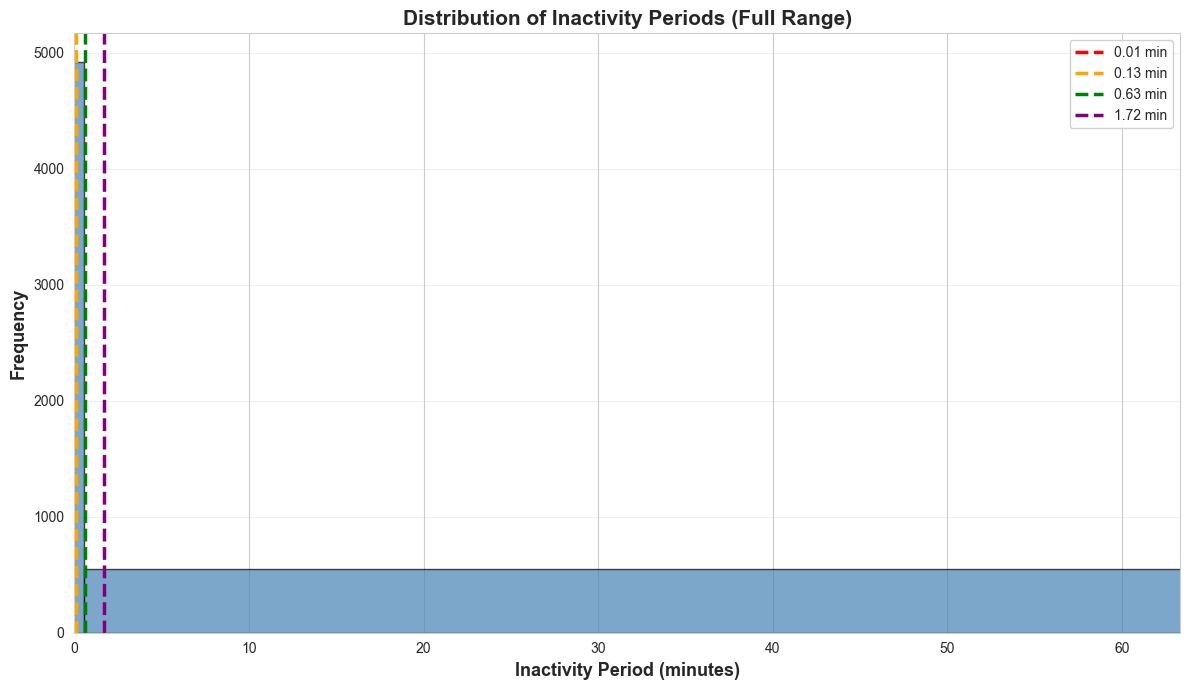

Saved: /Users/hamidaho/new_cursor/research/results/inactivity_distribution_zoomed.png


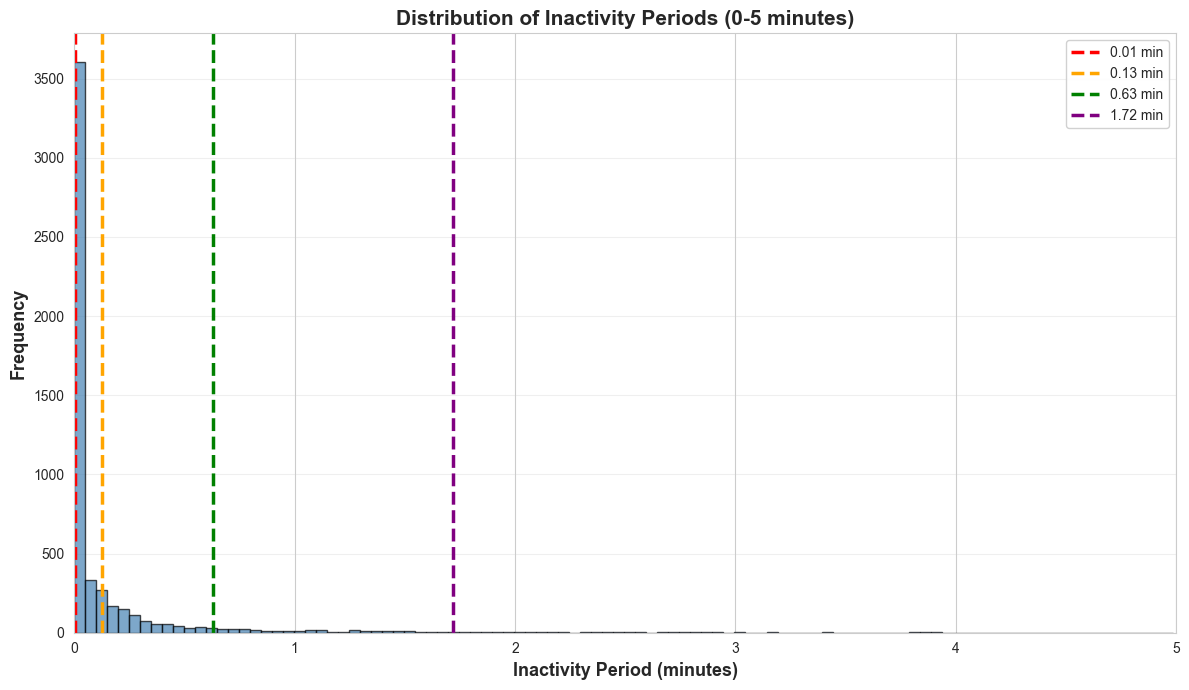

Saved: /Users/hamidaho/new_cursor/research/results/threshold_segments_f1_3d.png


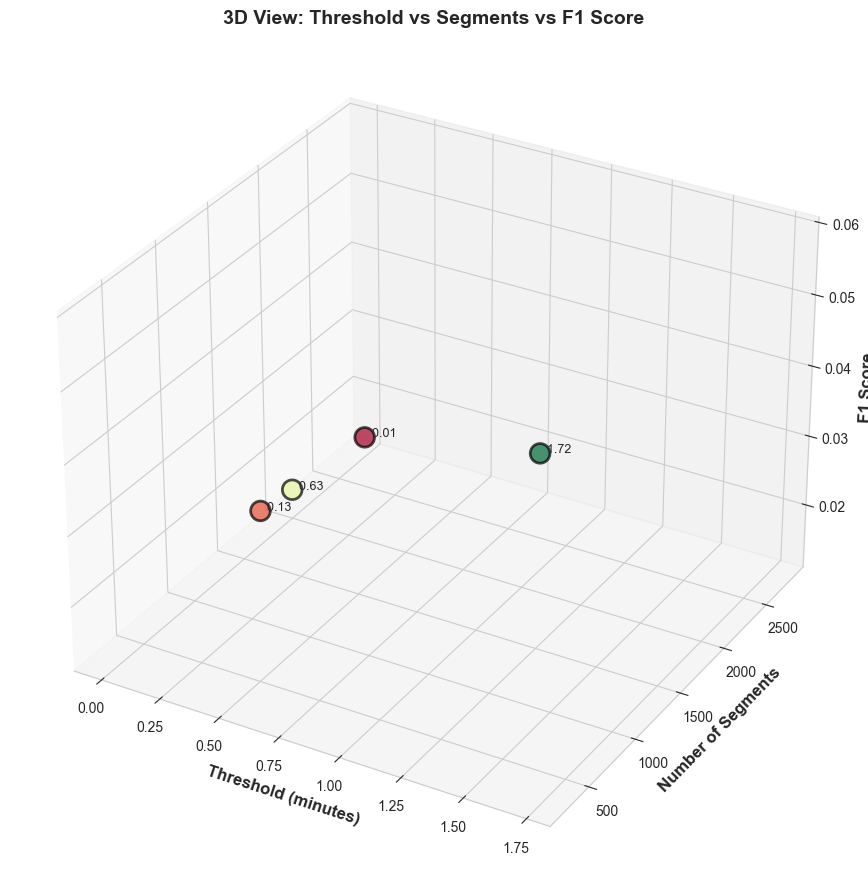


✅ All visualizations saved to: /Users/hamidaho/new_cursor/research/results
Saved results to JSON: /Users/hamidaho/new_cursor/research/results/temporal_segmentation_inactivity_results.json

BEST STRATEGY (by F1 Score)
Strategy: Inactivity (95th percentile)
Inactivity Threshold: 1.72 minutes

Performance Metrics:
   - Completeness: 0.407
   - Homogeneity: 0.576
   - Precision: 0.031
   - Recall: 0.407
   - F1: 0.058
   - ARI: 0.031
   - NMI: 0.271
   - Boundary F1: 0.895

Segmentation Statistics:
   - Number of Segments: 278
   - Average Segment Size: 19.9 traces


In [ ]:
# Import Altair and plotting utilities
import altair as alt
import sys
from pathlib import Path

# Add research scripts to path for plotting utilities
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / 'research').exists() and REPO_ROOT != REPO_ROOT.parent:
    REPO_ROOT = REPO_ROOT.parent

RESEARCH_DIR = REPO_ROOT / 'research'
SCRIPTS_DIR = RESEARCH_DIR / 'scripts'
if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))

# Import from visualization module (scripts/visualization is now in path)
from visualization.plotting_utils import (
    plot_bar,
    plot_scatter,
    plot_line,
    save_chart,
    configure_chart,
    COLOR_PALETTE,
    CHART_CONFIG,
)

alt.renderers.enable('default')
alt.data_transformers.enable('default')

# ============================================================================
# Plot 1: Completeness vs Homogeneity - Small Multiples with Error Bars
# ============================================================================

def bootstrap_evaluation(ground_truth, predicted_segments, traces, n_bootstrap=30):
    """Bootstrap evaluation by resampling traces and remapping segments."""
    n_traces = len(traces)
    bootstrap_completeness = []
    bootstrap_homogeneity = []
    
    # Build reverse lookup: trace_idx -> segment_id for both GT and predicted
    gt_trace_to_seg = {}
    for seg_id, seg in enumerate(ground_truth.ground_truth_segments):
        for trace_idx in seg:
            if trace_idx < n_traces:
                gt_trace_to_seg[trace_idx] = seg_id
    
    pred_trace_to_seg = {}
    for seg_id, seg in enumerate(predicted_segments):
        for trace_idx in seg:
            if trace_idx < n_traces:
                pred_trace_to_seg[trace_idx] = seg_id
    
    for _ in range(n_bootstrap):
        # Bootstrap sample: sample trace indices with replacement
        boot_indices = np.random.choice(n_traces, size=n_traces, replace=True)
        
        # Create new segment assignments for bootstrapped traces
        # Map: new_position -> original_trace_idx -> segment_id
        boot_gt_segments = {}
        boot_pred_segments = {}
        
        for new_pos, orig_idx in enumerate(boot_indices):
            # Ground truth mapping
            if orig_idx in gt_trace_to_seg:
                seg_id = gt_trace_to_seg[orig_idx]
                if seg_id not in boot_gt_segments:
                    boot_gt_segments[seg_id] = []
                boot_gt_segments[seg_id].append(new_pos)
            
            # Predicted mapping
            if orig_idx in pred_trace_to_seg:
                seg_id = pred_trace_to_seg[orig_idx]
                if seg_id not in boot_pred_segments:
                    boot_pred_segments[seg_id] = []
                boot_pred_segments[seg_id].append(new_pos)
        
        # Convert to lists
        boot_gt_list = list(boot_gt_segments.values())
        boot_pred_list = list(boot_pred_segments.values())
        
        # Create bootstrapped traces
        boot_traces = [traces[i] for i in boot_indices]
        
        # Evaluate
        boot_gt = GroundTruthResult(ground_truth_segments=boot_gt_list)
        try:
            eval_result = evaluate_segmentation_strategy(boot_gt, boot_pred_list, boot_traces)
            bootstrap_completeness.append(eval_result['completeness'])
            bootstrap_homogeneity.append(eval_result['homogeneity'])
        except:
            continue
    
    if bootstrap_completeness and len(bootstrap_completeness) >= 10:
        return {
            'completeness_ci_lower': np.percentile(bootstrap_completeness, 2.5),
            'completeness_ci_upper': np.percentile(bootstrap_completeness, 97.5),
            'homogeneity_ci_lower': np.percentile(bootstrap_homogeneity, 2.5),
            'homogeneity_ci_upper': np.percentile(bootstrap_homogeneity, 97.5),
        }
    return None

# Compute bootstrap confidence intervals for each strategy
print("Computing bootstrap confidence intervals (this may take a minute)...")
bootstrap_results = {}
for idx, row in results_df.iterrows():
    try:
        # Get the predicted segments for this strategy
        # Re-segment using the same threshold
        percentile = row['percentile']
        predicted_segments = segment_by_inactivity(traces, inactivity_threshold_percentile=percentile)
        
        # Bootstrap (using fewer samples for speed)
        boot_result = bootstrap_evaluation(ground_truth, predicted_segments, traces, n_bootstrap=30)
        if boot_result:
            bootstrap_results[idx] = boot_result
            print(f"  ✓ {row['strategy']}: CI computed")
        else:
            print(f"  ⚠ {row['strategy']}: Bootstrap failed, skipping CI")
    except Exception as e:
        print(f"  ✗ {row['strategy']}: Error - {e}")
        continue

# Save bootstrap results to JSON
bootstrap_results_file = RESULTS_DIR / 'bootstrap_results.json'
bootstrap_data = {}
for idx, row in results_df.iterrows():
    if idx in bootstrap_results:
        boot = bootstrap_results[idx]
        bootstrap_data[row['strategy']] = {
            'strategy': row['strategy'],
            'percentile': float(row['percentile']),
            'completeness_ci_lower': float(boot['completeness_ci_lower']),
            'completeness_ci_upper': float(boot['completeness_ci_upper']),
            'homogeneity_ci_lower': float(boot['homogeneity_ci_lower']),
            'homogeneity_ci_upper': float(boot['homogeneity_ci_upper']),
            'n_bootstrap': int(boot.get('n_bootstrap', 30))
        }
with open(bootstrap_results_file, 'w') as f:
    json.dump(bootstrap_data, f, indent=2)
print(f"\nSaved bootstrap results to: {bootstrap_results_file}")

# Create small-multiples plot: two panels side by side (Altair)
# Sort by threshold for line plot
sorted_df = results_df.sort_values('threshold_minutes').copy()

# ============================================================================
# Panel 1: Completeness vs Threshold
# ============================================================================
# Prepare data with error bars
complete_data = []
for idx in sorted_df.index:
    row = sorted_df.loc[idx]
    entry = {
        'threshold_minutes': float(row['threshold_minutes']),
        'completeness': float(row['completeness']),
        'ci_lower': 0.0,
        'ci_upper': 0.0
    }
    if idx in bootstrap_results:
        boot = bootstrap_results[idx]
        val = float(row['completeness'])
        entry['ci_lower'] = max(0.0, float(val - boot['completeness_ci_lower']))
        entry['ci_upper'] = max(0.0, float(boot['completeness_ci_upper'] - val))
    complete_data.append(entry)

complete_df = pd.DataFrame(complete_data)

# Create base chart with line
base1 = alt.Chart(complete_df).mark_line(
    strokeWidth=2.5, color='#82a7a6', point=True
).encode(
    x=alt.X('threshold_minutes:Q', title='Inactivity Threshold (minutes)',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('completeness:Q', title='Completeness',
           scale=alt.Scale(domain=[0, complete_df['completeness'].max() * 1.15]),
           axis=alt.Axis(titleFontWeight='bold')),
    tooltip=['threshold_minutes', alt.Tooltip('completeness:Q', format='.3f')]
)

# Add confidence band
complete_df['y_lower'] = complete_df['completeness'] - complete_df['ci_lower']
complete_df['y_upper'] = complete_df['completeness'] + complete_df['ci_upper']
band1 = alt.Chart(complete_df).mark_area(
    opacity=0.2, color='#82a7a6'
).encode(
    x='threshold_minutes:Q',
    y=alt.Y('y_lower:Q', title='Completeness'),
    y2='y_upper:Q'
)

# Add error bars
error_bars1 = alt.Chart(complete_df).mark_rule(
    strokeWidth=2, color='#82a7a6', opacity=0.6
).encode(
    x='threshold_minutes:Q',
    y=alt.Y('y_lower:Q', title='Completeness'),
    y2='y_upper:Q'
)

chart1 = (band1 + error_bars1 + base1).properties(
    width=400, height=300,
    title=alt.TitleParams(
        text='Completeness vs Inactivity Threshold (with 95% Confidence Intervals)',
        fontWeight='bold', fontSize=14
    )
)
chart1 = configure_chart(chart1)

# ============================================================================
# Panel 2: Homogeneity vs Threshold
# ============================================================================
# Prepare data with error bars
homo_data = []
for idx in sorted_df.index:
    row = sorted_df.loc[idx]
    entry = {
        'threshold_minutes': float(row['threshold_minutes']),
        'homogeneity': float(row['homogeneity']),
        'ci_lower': 0.0,
        'ci_upper': 0.0
    }
    if idx in bootstrap_results:
        boot = bootstrap_results[idx]
        val = float(row['homogeneity'])
        entry['ci_lower'] = max(0.0, float(val - boot['homogeneity_ci_lower']))
        entry['ci_upper'] = max(0.0, float(boot['homogeneity_ci_upper'] - val))
    homo_data.append(entry)

homo_df = pd.DataFrame(homo_data)

# Create base chart with line
base2 = alt.Chart(homo_df).mark_line(
    strokeWidth=2.5, color='#b57c61', point=True
).encode(
    x=alt.X('threshold_minutes:Q', title='Inactivity Threshold (minutes)',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('homogeneity:Q', title='Homogeneity',
           scale=alt.Scale(domain=[homo_df['homogeneity'].min() * 0.95, 1.05]),
           axis=alt.Axis(titleFontWeight='bold')),
    tooltip=['threshold_minutes', alt.Tooltip('homogeneity:Q', format='.3f')]
)

# Add confidence band
homo_df['y_lower'] = homo_df['homogeneity'] - homo_df['ci_lower']
homo_df['y_upper'] = homo_df['homogeneity'] + homo_df['ci_upper']
band2 = alt.Chart(homo_df).mark_area(
    opacity=0.2, color='#b57c61'
).encode(
    x='threshold_minutes:Q',
    y=alt.Y('y_lower:Q', title='Homogeneity'),
    y2='y_upper:Q'
)

# Add error bars
error_bars2 = alt.Chart(homo_df).mark_rule(
    strokeWidth=2, color='#b57c61', opacity=0.6
).encode(
    x='threshold_minutes:Q',
    y=alt.Y('y_lower:Q', title='Homogeneity'),
    y2='y_upper:Q'
)

chart2 = (band2 + error_bars2 + base2).properties(
    width=400, height=300,
    title=alt.TitleParams(
        text='Homogeneity vs Inactivity Threshold (with 95% Confidence Intervals)',
        fontWeight='bold', fontSize=14
    )
)
chart2 = configure_chart(chart2)

# Combine panels
dashboard = alt.hconcat(chart1, chart2, spacing=30).properties(
    title=alt.TitleParams(
        text='Completeness and Homogeneity Trade-off with Inactivity Threshold',
        fontWeight='bold', fontSize=16
    )
)
dashboard

# Save dashboard
save_chart(dashboard, RESULTS_DIR / 'completeness_vs_homogeneity.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'completeness_vs_homogeneity.png'}")

# ============================================================================
# Alternative: Combined scatter plot with error bars and confidence regions
# ============================================================================
# Prepare data with confidence intervals
scatter_data = []
for idx, row in results_df.iterrows():
    entry = {
        'completeness': float(row['completeness']),
        'homogeneity': float(row['homogeneity']),
        'threshold_minutes': float(row['threshold_minutes']),
        'f1': float(row['f1']),
        'x_lower': float(row['completeness']),
        'x_upper': float(row['completeness']),
        'y_lower': float(row['homogeneity']),
        'y_upper': float(row['homogeneity'])
    }
    if idx in bootstrap_results:
        boot = bootstrap_results[idx]
        entry['x_lower'] = float(boot['completeness_ci_lower'])
        entry['x_upper'] = float(boot['completeness_ci_upper'])
        entry['y_lower'] = float(boot['homogeneity_ci_lower'])
        entry['y_upper'] = float(boot['homogeneity_ci_upper'])
    scatter_data.append(entry)

scatter_df = pd.DataFrame(scatter_data)
scatter_df['size'] = 400 + scatter_df['f1'] * 1500

# Create confidence rectangles (more subtle)
rects = alt.Chart(scatter_df).mark_rect(
    opacity=0.08, color='gray', stroke='gray', strokeDash=[3, 3], strokeWidth=0.5
).encode(
    x=alt.X('x_lower:Q', title='Completeness',
           scale=alt.Scale(domain=[-0.05, scatter_df['completeness'].max() * 1.15]),
           axis=alt.Axis(titleFontWeight='bold')),
    x2='x_upper:Q',
    y=alt.Y('y_lower:Q', title='Homogeneity',
           scale=alt.Scale(domain=[scatter_df['homogeneity'].min() * 0.95, 1.05]),
           axis=alt.Axis(titleFontWeight='bold')),
    y2='y_upper:Q'
)

# Create trajectory line (more subtle)
sorted_scatter = scatter_df.sort_values('threshold_minutes')
trajectory = alt.Chart(sorted_scatter).mark_line(
    stroke='gray', strokeDash=[4, 4], strokeWidth=1.5, opacity=0.4
).encode(
    x='completeness:Q',
    y='homogeneity:Q',
    order='threshold_minutes:Q'
)

# Create scatter points with improved styling
points = alt.Chart(scatter_df).mark_circle(
    stroke='black', strokeWidth=2.5, opacity=0.95
).encode(
    x='completeness:Q',
    y='homogeneity:Q',
    size=alt.Size('size:Q', legend=None, scale=alt.Scale(range=[400, 1200])),
    color=alt.Color('threshold_minutes:Q',
                   scale=alt.Scale(scheme='viridis'),
                   legend=alt.Legend(title='Threshold (minutes)', titleFontWeight='bold')),
    tooltip=['threshold_minutes', 'completeness', 'homogeneity', 'f1']
)

# Add labels with F1 values in white on top of dots
labels = alt.Chart(scatter_df).mark_text(
    fontSize=11, fontWeight='bold', color='white', align='center', baseline='middle',
    dy=-2  # Slight offset above the point
).encode(
    x='completeness:Q',
    y='homogeneity:Q',
    text=alt.Text('f1:Q', format='.3f')
)

# Combine all layers
chart_scatter = (rects + trajectory + points + labels).properties(
    width=500, height=500,
    title=alt.TitleParams(
        text='Completeness vs Homogeneity (with Bootstrap 95% Confidence Intervals)',
        fontWeight='bold', fontSize=14
    )
)
chart_scatter = configure_chart(chart_scatter)
chart_scatter

# Save chart
save_chart(chart_scatter, RESULTS_DIR / 'completeness_vs_homogeneity_scatter.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'completeness_vs_homogeneity_scatter.png'}")

# ============================================================================
# Plot 2: Metrics vs Threshold (minutes) - Main metrics with confidence bands (Altair)
# ============================================================================
main_metrics = ['completeness', 'homogeneity', 'f1', 'boundary_f1']
colors_main = ['#82a7a6', '#b57c61', '#73648a', '#5c4e6d']

# Prepare data for main metrics
main_data = []
sorted_df_plot = results_df.sort_values('threshold_minutes')
for idx in sorted_df_plot.index:
    row = sorted_df_plot.loc[idx]
    for metric in main_metrics:
        entry = {
            'threshold_minutes': float(row['threshold_minutes']),
            'metric': metric.replace('_', ' ').title(),
            'value': float(row[metric]),
            'y_lower': float(row[metric]),
            'y_upper': float(row[metric])
        }
        # Add confidence intervals for completeness and homogeneity
        if metric in ['completeness', 'homogeneity'] and idx in bootstrap_results:
            boot = bootstrap_results[idx]
            if metric == 'completeness':
                entry['y_lower'] = float(boot['completeness_ci_lower'])
                entry['y_upper'] = float(boot['completeness_ci_upper'])
            else:
                entry['y_lower'] = float(boot['homogeneity_ci_lower'])
                entry['y_upper'] = float(boot['homogeneity_ci_upper'])
        main_data.append(entry)

main_df = pd.DataFrame(main_data)

# Create base line chart
base_main = alt.Chart(main_df).mark_line(
    point=True, strokeWidth=2.5
).encode(
    x=alt.X('threshold_minutes:Q', title='Inactivity Threshold (minutes)',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('value:Q', title='Score',
           scale=alt.Scale(domain=[0, 1.05]),
           axis=alt.Axis(titleFontWeight='bold')),
    color=alt.Color('metric:N',
                   scale=alt.Scale(domain=[m.replace('_', ' ').title() for m in main_metrics],
                                 range=colors_main),
                   legend=alt.Legend(title='Metric', titleFontWeight='bold')),
    tooltip=['metric', 'threshold_minutes', alt.Tooltip('value:Q', format='.3f')]
)

# Add confidence bands for completeness and homogeneity
bands_main = alt.Chart(main_df[main_df['metric'].isin(['Completeness', 'Homogeneity'])]).mark_area(
    opacity=0.15
).encode(
    x='threshold_minutes:Q',
    y=alt.Y('y_lower:Q', title='Score'),
    y2='y_upper:Q',
    color=alt.Color('metric:N',
                   scale=alt.Scale(domain=['Completeness', 'Homogeneity'],
                                 range=['#82a7a6', '#b57c61']),
                   legend=None)
)

chart_main = (bands_main + base_main).properties(
    width=600, height=400,
    title=alt.TitleParams(text='Key Metrics vs Inactivity Threshold', fontWeight='bold', fontSize=15)
)
chart_main = configure_chart(chart_main)
chart_main

# Save chart
save_chart(chart_main, RESULTS_DIR / 'metrics_vs_threshold_main.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'metrics_vs_threshold_main.png'}")

# ============================================================================
# Plot 3: All Metrics vs Threshold (minutes) - Comprehensive view (Altair)
# ============================================================================
all_metrics = ['completeness', 'homogeneity', 'precision', 'recall', 'f1', 'ari', 'nmi', 'boundary_f1']
all_colors = ['#82a7a6', '#b57c61', '#73648a', '#5c4e6d', '#453750', '#82a7a6', '#b57c61', '#73648a']

# Prepare data for all metrics
all_data = []
for idx, row in results_df.iterrows():
    for metric in all_metrics:
        label = metric.upper() if metric in ['ari', 'nmi'] else metric.replace('_', ' ').title()
        all_data.append({
            'threshold_minutes': float(row['threshold_minutes']),
            'metric': label,
            'value': float(row[metric])
        })

all_df = pd.DataFrame(all_data)

chart_all = alt.Chart(all_df).mark_line(
    point=True, strokeWidth=2
).encode(
    x=alt.X('threshold_minutes:Q', title='Inactivity Threshold (minutes)',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('value:Q', title='Score',
           scale=alt.Scale(domain=[0, 1.05]),
           axis=alt.Axis(titleFontWeight='bold')),
    color=alt.Color('metric:N',
                   scale=alt.Scale(domain=[m.upper() if m in ['ari', 'nmi'] else m.replace('_', ' ').title() 
                                          for m in all_metrics],
                                 range=all_colors),
                   legend=alt.Legend(title='Metric', titleFontWeight='bold', columns=2)),
    tooltip=['metric', 'threshold_minutes', alt.Tooltip('value:Q', format='.3f')]
).properties(
    width=600, height=400,
    title=alt.TitleParams(text='All Metrics vs Inactivity Threshold', fontWeight='bold', fontSize=15)
)
chart_all = configure_chart(chart_all)
chart_all

# Save chart
save_chart(chart_all, RESULTS_DIR / 'metrics_vs_threshold_all.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'metrics_vs_threshold_all.png'}")

# ============================================================================
# Plot 4: Number of Segments vs Threshold (Altair - dual encoding)
# ============================================================================
segments_data = results_df[['threshold_minutes', 'n_segments']].copy()
segments_data.columns = ['threshold_minutes', 'n_segments']

# Create base chart for segments
base_segments = alt.Chart(segments_data).mark_line(
    point=True, strokeWidth=2.5, color='#82a7a6'
).encode(
    x=alt.X('threshold_minutes:Q', title='Inactivity Threshold (minutes)',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('n_segments:Q', title='Number of Segments',
           axis=alt.Axis(titleFontWeight='bold', titleColor='#82a7a6')),
    tooltip=['threshold_minutes', 'n_segments']
)

# Add threshold line (y=x)
threshold_line = alt.Chart(segments_data).mark_line(
    strokeDash=[5, 5], strokeWidth=2, color='#b57c61', opacity=0.7
).encode(
    x='threshold_minutes:Q',
    y='threshold_minutes:Q'
)

# Combine charts (Altair doesn't support true dual y-axis, so we use layered approach)
chart_segments = (base_segments + threshold_line).properties(
    width=600, height=400,
    title=alt.TitleParams(
        text='Segmentation Granularity vs Inactivity Threshold',
        fontWeight='bold', fontSize=15
    )
)
chart_segments = configure_chart(chart_segments)
chart_segments

# Save chart
save_chart(chart_segments, RESULTS_DIR / 'segments_vs_threshold.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'segments_vs_threshold.png'}")

# ============================================================================
# Plot 5: F1 Score vs Number of Segments (Trade-off analysis) (Altair)
# ============================================================================
# Sort by number of segments for line plot
f1_segments_data = results_df[['n_segments', 'f1', 'threshold_minutes']].copy()
f1_segments_data = f1_segments_data.sort_values('n_segments')

# Create line chart
chart_f1 = alt.Chart(f1_segments_data).mark_line(
    point=True, strokeWidth=3, color='#73648a'
).encode(
    x=alt.X('n_segments:Q', title='Number of Segments',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('f1:Q', title='F1 Score',
           scale=alt.Scale(domain=[0, f1_segments_data['f1'].max() * 1.1]),
           axis=alt.Axis(titleFontWeight='bold')),
    tooltip=['n_segments', alt.Tooltip('f1:Q', format='.3f'), 'threshold_minutes']
).properties(
    width=600,
    height=400,
    title=alt.TitleParams(
        text='F1 Score vs Segmentation Granularity',
        fontWeight='bold', fontSize=15
    )
)

# Add point labels with threshold values
labels_f1 = alt.Chart(f1_segments_data).mark_text(
    fontSize=10, fontWeight='bold', color='white', align='center', baseline='middle',
    dy=-5
).encode(
    x='n_segments:Q',
    y='f1:Q',
    text=alt.Text('threshold_minutes:Q', format='.2f')
)

chart_f1 = (chart_f1 + labels_f1)
chart_f1 = configure_chart(chart_f1)
chart_f1

# Save chart
save_chart(chart_f1, RESULTS_DIR / 'f1_vs_segments.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'f1_vs_segments.png'}")

# ============================================================================
# Plot 7: Inactivity Period Distribution (Zoomed: 0-5 minutes) (Altair)
# ============================================================================
if inactivity_periods:
    # Filter data for 0-5 minutes
    filtered_periods = [p for p in inactivity_periods if 0 <= p <= 5]
    hist_data_zoom = pd.DataFrame({'inactivity_period': filtered_periods})
    
    # Create histogram with log scale on y-axis
    chart_hist_zoom = alt.Chart(hist_data_zoom).mark_bar(
        cornerRadius=2, stroke='black', strokeWidth=1, opacity=0.7, color='#82a7a6'
    ).encode(
        x=alt.X('inactivity_period:Q', title='Inactivity Period (minutes)',
               bin=alt.Bin(maxbins=100),
               scale=alt.Scale(domain=[0, 5]),
               axis=alt.Axis(titleFontWeight='bold')),
        y=alt.Y('count():Q', title='Frequency (log scale)', 
               scale=alt.Scale(type='log', nice=False),
               axis=alt.Axis(titleFontWeight='bold')),
        tooltip=[alt.Tooltip('inactivity_period:Q', bin=True, format='.2f'), 'count():Q']
    )
    
    # Add threshold lines (only those <= 5)
    sorted_results = results_df.sort_values('threshold_minutes')
    threshold_colors = ['#d62728', '#ff7f0e', '#2ca02c', '#9467bd']
    threshold_lines_zoom = []
    for i, (idx, row) in enumerate(sorted_results.iterrows()):
        threshold = row['threshold_minutes']
        if threshold <= 5:
            line = alt.Chart(pd.DataFrame({'x': [threshold]})).mark_rule(
                stroke=threshold_colors[i % len(threshold_colors)],
                strokeDash=[5, 5],
                strokeWidth=2.5
            ).encode(x='x:Q')
            threshold_lines_zoom.append(line)
    
    # Combine histogram and threshold lines
    if threshold_lines_zoom:
        chart_hist_zoom = chart_hist_zoom + alt.layer(*threshold_lines_zoom)
    
    chart_hist_zoom = chart_hist_zoom.properties(
        width=600, height=400,
        title=alt.TitleParams(
            text='Distribution of Inactivity Periods (0-5 minutes)',
            fontWeight='bold', fontSize=15
        )
    )
    chart_hist_zoom = configure_chart(chart_hist_zoom)
    chart_hist_zoom
    
    # Save chart
    save_chart(chart_hist_zoom, RESULTS_DIR / 'inactivity_distribution_zoomed.png', scale_factor=2.0)
    print(f"Saved: {RESULTS_DIR / 'inactivity_distribution_zoomed.png'}")

# ============================================================================
# Plot 8: Three-axis plot: Threshold vs Segments vs F1 (Altair - 2D alternative)
# Note: Altair doesn't support 3D plots, so we create a 2D scatter with size/color encoding
# ============================================================================
# Prepare data - sort by threshold for better visualization
plot8_data = results_df[['threshold_minutes', 'n_segments', 'f1']].copy()
plot8_data = plot8_data.sort_values('threshold_minutes')

# Create scatter plot with F1 as color and size, using log scale for segments
chart_3d_alt = alt.Chart(plot8_data).mark_circle(
    stroke='black', strokeWidth=2.5, opacity=0.8
).encode(
    x=alt.X('threshold_minutes:Q', title='Threshold (minutes)',
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('n_segments:Q', title='Number of Segments (log scale)',
           scale=alt.Scale(type='log', nice=False),
           axis=alt.Axis(titleFontWeight='bold')),
    size=alt.Size('f1:Q',
                 scale=alt.Scale(range=[300, 900]),
                 legend=alt.Legend(title='F1 Score', titleFontWeight='bold')),
    color=alt.Color('f1:Q',
                   scale=alt.Scale(scheme='RdYlGn', domain=[plot8_data['f1'].min(), plot8_data['f1'].max()]),
                   legend=alt.Legend(title='F1 Score', titleFontWeight='bold')),
    tooltip=['threshold_minutes', 'n_segments', alt.Tooltip('f1:Q', format='.3f')]
).properties(
    width=600, height=500,
    title=alt.TitleParams(
        text='Threshold vs Segments vs F1 Score',
        fontWeight='bold', fontSize=14
    )
)

# Add connecting line to show trajectory
trajectory_3d = alt.Chart(plot8_data).mark_line(
    stroke='gray', strokeWidth=1.5, strokeDash=[3, 3], opacity=0.4
).encode(
    x='threshold_minutes:Q',
    y='n_segments:Q',
    order='threshold_minutes:Q'
)

# Add labels with F1 values
labels_3d = alt.Chart(plot8_data).mark_text(
    fontSize=10, fontWeight='bold', color='white', align='center', baseline='middle',
    dy=-3
).encode(
    x='threshold_minutes:Q',
    y='n_segments:Q',
    text=alt.Text('f1:Q', format='.3f')
)

chart_3d_alt = (trajectory_3d + chart_3d_alt + labels_3d).resolve_scale(color='independent', size='independent')
chart_3d_alt = configure_chart(chart_3d_alt)
chart_3d_alt

# Save chart
save_chart(chart_3d_alt, RESULTS_DIR / 'threshold_segments_f1_3d.png', scale_factor=2.0)
print(f"Saved: {RESULTS_DIR / 'threshold_segments_f1_3d.png'}")
print("Note: 3D plot converted to 2D scatter (Altair limitation)")

print(f"\n✅ All visualizations saved to: {RESULTS_DIR}")

# Save results to JSON (for programmatic access)
json_file = RESULTS_DIR / 'temporal_segmentation_inactivity_results.json'
results_list = []
for idx, row in results_df.iterrows():
    result_entry = {
        'strategy': row['strategy'],
        'percentile': float(row['percentile']),
        'threshold_minutes': float(row['threshold_minutes']),
        'n_segments': int(row['n_segments']),
        'avg_segment_size': float(row['avg_segment_size']),
        'completeness': float(row['completeness']),
        'homogeneity': float(row['homogeneity']),
        'precision': float(row['precision']),
        'recall': float(row['recall']),
        'f1': float(row['f1']),
        'ari': float(row['ari']),
        'nmi': float(row['nmi']),
        'boundary_precision': float(row['boundary_precision']),
        'boundary_recall': float(row['boundary_recall']),
        'boundary_f1': float(row['boundary_f1'])
    }
    # Add bootstrap confidence intervals if available
    if idx in bootstrap_results:
        boot = bootstrap_results[idx]
        result_entry['bootstrap_confidence_intervals'] = {
            'completeness_ci_lower': float(boot['completeness_ci_lower']),
            'completeness_ci_upper': float(boot['completeness_ci_upper']),
            'homogeneity_ci_lower': float(boot['homogeneity_ci_lower']),
            'homogeneity_ci_upper': float(boot['homogeneity_ci_upper'])
        }
    results_list.append(result_entry)

results_data = {
    'results': results_list,
    'metadata': {
        'total_strategies': len(results_list),
        'best_strategy': results_list[0]['strategy'] if results_list else None,
        'best_f1': results_list[0]['f1'] if results_list else None
    }
}

with open(json_file, 'w') as f:
    json.dump(results_data, f, indent=2)
print(f"Saved results to JSON: {json_file}")

# Find best strategy (by F1 score)
if len(results_df) > 0:
    best = results_df.iloc[0]
    print(f"\n{'='*80}")
    print("BEST STRATEGY (by F1 Score)")
    print(f"{'='*80}")
    print(f"Strategy: {best['strategy']}")
    print(f"Inactivity Threshold: {best['threshold_minutes']:.2f} minutes")
    print(f"\nPerformance Metrics:")
    print(f"   - Completeness: {best['completeness']:.3f}")
    print(f"   - Homogeneity: {best['homogeneity']:.3f}")
    print(f"   - Precision: {best['precision']:.3f}")
    print(f"   - Recall: {best['recall']:.3f}")
    print(f"   - F1: {best['f1']:.3f}")
    print(f"   - ARI: {best['ari']:.3f}")
    print(f"   - NMI: {best['nmi']:.3f}")
    print(f"   - Boundary F1: {best['boundary_f1']:.3f}")
    print(f"\nSegmentation Statistics:")
    print(f"   - Number of Segments: {int(best['n_segments'])}")
    print(f"   - Average Segment Size: {best['avg_segment_size']:.1f} traces")
    print(f"{'='*80}")
